# Машинное обучение, ФЭН ВШЭ

__Дата выдачи: 26.11.2017__
__Дедлайн: 15.12.2017 23:59__

# Практическое задание 4


### О задании

Практическое задание 4 посвящено ансамблям, bias-variance decomposition, деревьям и нейронным сетям. Обучение нейронных сетей займет какое-то время, поэтому не оставляйте эту часть на последний день!

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник). 

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: *HW4_Username.ipynb*, где *Username* — Ваша фамилия и инициалы на латинице (например, *HW4_IvanovII.ipynb*). Далее отправьте этот файл на *ml.econom.hse@gmail.com* с темой *Практика {номер задания} - номер группы по данному курсу - Фамилия Имя* 

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \frac 1 m \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [6]:
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score
from sklearn import tree
from sklearn import linear_model as lm
from sklearn import svm
import pandas as pd
import requests
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [2]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

34.077220371309608

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [3]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.820020606449173

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
#####  Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [207]:
from matplotlib import pyplot as plt
%matplotlib inline

In [208]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.6 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

In [209]:
#1
X = np.random.exponential(size = sample_size)

In [210]:
#2
u = np.random.uniform(low=-1, high=1.0, size=sample_size)
y = f(X)+u

In [211]:
#3
clf = tree.DecisionTreeRegressor()
clf.fit(X.reshape(100,1), y)
pred = clf.predict(linspace.reshape(1000,1))

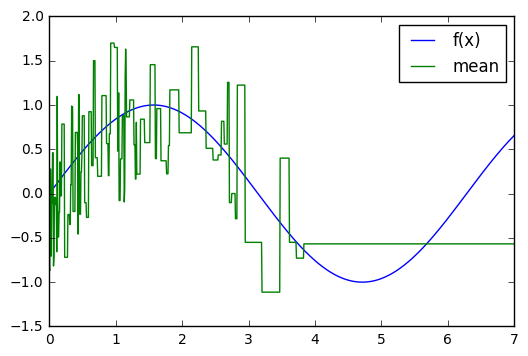

In [213]:
plt.plot(linspace, f(linspace), label = 'f(x)') 
plt.plot(linspace, pred, label = 'mean' )
plt.legend()
plt.show()

__2 (0.6 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

In [214]:
mat_pred = np.zeros((samples_num,1000))
for i in range(samples_num):
    X = np.random.exponential(size = sample_size)
    u = np.random.uniform(low=-1, high=1.0, size=sample_size)
    y = f(X)+u
    clf = tree.DecisionTreeRegressor()
    clf.fit(X.reshape(100,1), y)
    pred = clf.predict(linspace.reshape(1000,1))
    mat_pred[i, :] = pred
   

In [215]:
clf.get_params
# как ви

<bound method BaseEstimator.get_params of DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')>

<function matplotlib.pyplot.show>

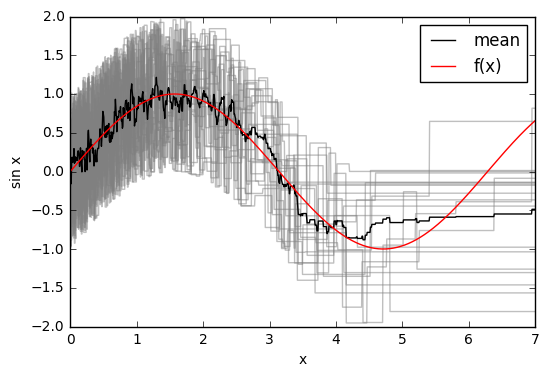

In [216]:
for i in range(20):
    plt.plot(linspace, mat_pred[i,:], color="gray", alpha=0.5)
plt.plot(linspace, np.mean(mat_pred,axis=0), color="black" , label = 'mean') 
plt.plot(linspace, f(linspace), color="red" , label = 'f(x)')
plt.xlabel('x')
plt.ylabel('sin x')
plt.legend()
plt.show    

__3 (0.2 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

<function matplotlib.pyplot.show>

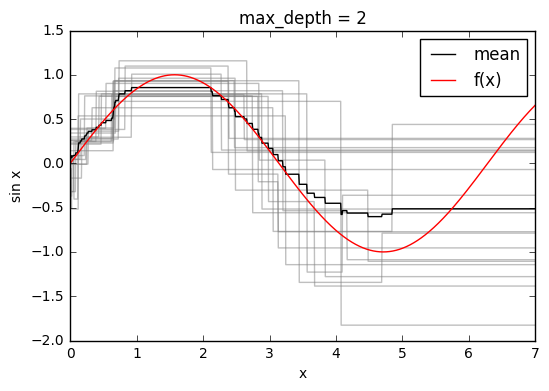

In [217]:
for i in range(samples_num):
    X = np.random.exponential(size = sample_size)
    u = np.random.uniform(low=-1, high=1.0, size=sample_size)
    y = f(X)+u
    clf = tree.DecisionTreeRegressor(max_depth = 2)
    clf.fit(X.reshape(100,1), y)
    pred = clf.predict(linspace.reshape(1000,1))
    mat_pred[i, :] = pred
    
        
for i in range(20):
    plt.plot(linspace, mat_pred[i,:], color="gray", alpha=0.5)
plt.plot(linspace, np.mean(mat_pred,axis=0), color="black", label = 'mean') 
plt.plot(linspace, f(linspace), color="red", label = 'f(x)')
plt.title('max_depth = 2')
plt.xlabel('x')
plt.ylabel('sin x')
plt.legend()
plt.show        

<function matplotlib.pyplot.show>

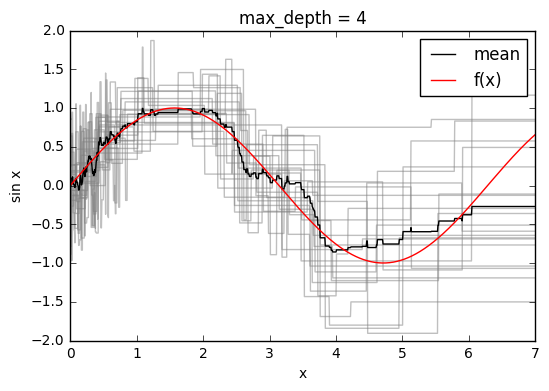

In [218]:
for i in range(samples_num):
    X = np.random.exponential(size = sample_size)
    u = np.random.uniform(low=-1, high=1.0, size=sample_size)
    y = f(X)+u
    clf = tree.DecisionTreeRegressor(max_depth = 4)
    clf.fit(X.reshape(100,1), y)
    pred = clf.predict(linspace.reshape(1000,1))
    mat_pred[i, :] = pred
    
        
for i in range(20):
    plt.plot(linspace, mat_pred[i,:], color="gray", alpha=0.5)
plt.plot(linspace, np.mean(mat_pred,axis=0), color="black", label = 'mean') 
plt.plot(linspace, f(linspace), color="red", label = 'f(x)')
plt.title('max_depth = 4')
plt.xlabel('x')
plt.ylabel('sin x')
plt.legend()
plt.show 

__4 (0.6 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

Визуально смещение в первом случае (без органичений) значительно меньше и близко к нулю по сравнению со вторым и третьим случаями.
Это можно объяснить тем, что большая глубина деревьев позволяет точнее описывать зависимости, хотя имеет риск переобучиться, который нивилируется
усреднением алгоритмов.

__5 (1 балл)__
Проделайте тот же эксперимент с линейной регрессией и SVM с rbf ядром и параматрами $\gamma = 1$, $\gamma = 100$. Какие выводы можно сделать?

//anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


<function matplotlib.pyplot.show>

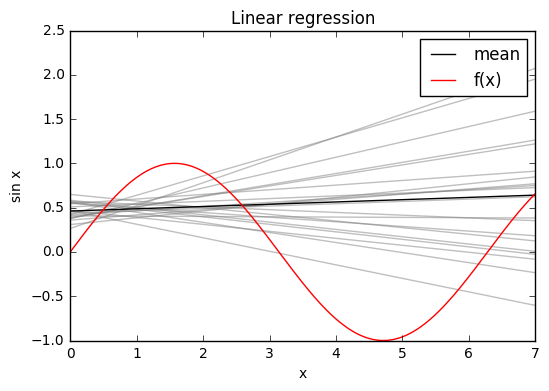

In [219]:
for i in range(samples_num):
    X = np.random.exponential(size = sample_size)
    u = np.random.uniform(low=-1, high=1.0, size=sample_size)
    y = f(X)+u
    clf = lm.LinearRegression()
    clf.fit(X.reshape(100,1), y)
    pred = clf.predict(linspace.reshape(1000,1))
    mat_pred[i, :] = pred
    
        
for i in range(20):
    plt.plot(linspace, mat_pred[i,:], color="gray", alpha=0.5)
plt.plot(linspace, np.mean(mat_pred,axis=0), color="black", label = 'mean') 
plt.plot(linspace, f(linspace), color="red", label = 'f(x)')
plt.title('Linear regression')
plt.xlabel('x')
plt.ylabel('sin x')
plt.legend()
plt.show 

<function matplotlib.pyplot.show>

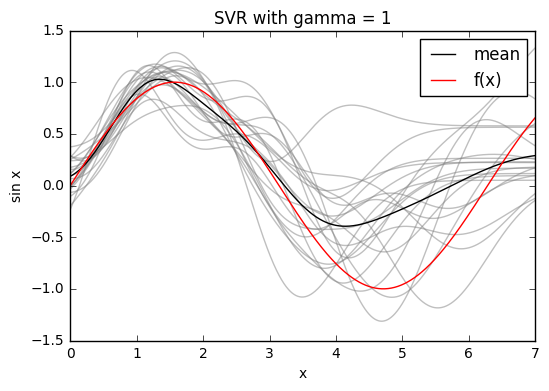

In [220]:
for i in range(samples_num):
    X = np.random.exponential(size = sample_size)
    u = np.random.uniform(low=-1, high=1.0, size=sample_size)
    y = f(X)+u
    clf = svm.SVR(gamma = 1)
    clf.fit(X.reshape(100,1), y)
    pred = clf.predict(linspace.reshape(1000,1))
    mat_pred[i, :] = pred
    
        
for i in range(20):
    plt.plot(linspace, mat_pred[i,:], color="gray", alpha=0.5)
plt.plot(linspace, np.mean(mat_pred,axis=0), color="black", label = 'mean') 
plt.plot(linspace, f(linspace), color="red", label = 'f(x)')
plt.title('SVR with gamma = 1')
plt.xlabel('x')
plt.ylabel('sin x')
plt.legend()
plt.show 

<function matplotlib.pyplot.show>

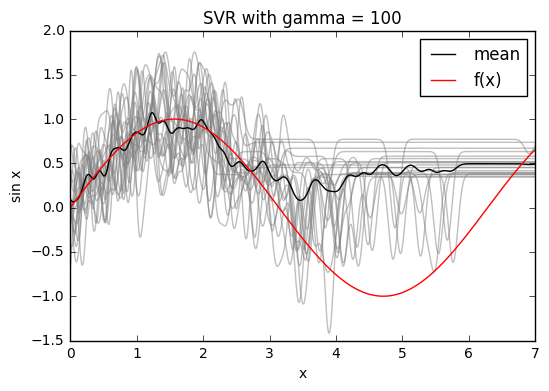

In [222]:
for i in range(samples_num):
    X = np.random.exponential(size = sample_size)
    u = np.random.uniform(low=-1, high=1.0, size=sample_size)
    y = f(X)+u
    clf = svm.SVR(gamma = 100)
    clf.fit(X.reshape(100,1), y)
    pred = clf.predict(linspace.reshape(1000,1))
    mat_pred[i, :] = pred
    
        
for i in range(20):
    plt.plot(linspace, mat_pred[i,:], color="gray", alpha=0.5)
plt.plot(linspace, np.mean(mat_pred,axis=0), color="black", label = 'mean') 
plt.plot(linspace, f(linspace), color="red",label = 'f(x)')
plt.title('SVR with gamma = 100')
plt.xlabel('x')
plt.ylabel('sin x')
plt.legend()
plt.show 

Однозначно линейная регрессия плохо справляется с задачей аппроксимации алгоритма, в силу того, что не может описывать нелинейные зависимости.
В то же время SVM с rbf хорошо справляется с данной задачей и имеет небольшое смещение при параметре gamma = 1; и плохо справляется с задачей при gamma = 100, так
как высокие значения параметра приводят к переобучению алгоритма на данных.

### II. Решающие деревья

__5 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nursery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recommend - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTreeClassifier, считающий все признаки вещественными
* DecisionTreeClassfier, считающий все признаки категориальными
* DecisionTreeClassifier, c корректным разбиением на категориальные и вещественные признаки.

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scoring=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.

In [91]:
url1="https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
df1 = pd.read_csv(url1, header = None)

In [92]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [93]:
val1 = df1.values

In [94]:
le = preprocessing.LabelEncoder()

In [95]:
for i in range(len(val1[1])):
         val1[:,i] = le.fit_transform(val1[:,i])

In [96]:
y = list(df1[0])
df = df1.drop(0, 1)
X = df.values

In [97]:
clf = tree.DecisionTreeClassifier()
a1 = np.mean(cross_val_score(clf, X, y, cv=10, scoring = make_scorer(accuracy_score)))

In [98]:
enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
onehot_X = onehot_encoder.fit_transform(X)

In [99]:
clf = tree.DecisionTreeClassifier()
a2 = np.mean(cross_val_score(clf, onehot_X, y, cv=10, scoring = make_scorer(accuracy_score)))

Чтобы рассматривать признаки как категориальные

Все признаки категориальные - то есть второе разбиение и есть корректное

In [100]:
url2='https://archive.ics.uci.edu/ml/machine-learning-databases/tic-tac-toe/tic-tac-toe.data'
df2 = pd.read_csv(url2, header = None)

In [101]:
df2.head()

,0,1,2,3,4,5,6,7,8,9
0,x,x,x,x,o,o,x,o,o,positive
1,x,x,x,x,o,o,o,x,o,positive
2,x,x,x,x,o,o,o,o,x,positive
3,x,x,x,x,o,o,o,b,b,positive
4,x,x,x,x,o,o,b,o,b,positive


In [102]:
val2 = df2.values

In [103]:
for i in range(len(val2[1])):
         val2[:,i] = le.fit_transform(val2[:,i])

In [104]:
y = list(df2[df2.shape[1]-1])
df = df2.drop(df2.shape[1]-1, 1)
X = df.values

In [105]:
clf = tree.DecisionTreeClassifier()
b1 = np.mean(cross_val_score(clf, X, y, cv=10, scoring = make_scorer(accuracy_score)))

In [106]:
enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
onehot_X = onehot_encoder.fit_transform(X)

In [107]:
clf = tree.DecisionTreeClassifier()
b2 = np.mean(cross_val_score(clf, onehot_X, y, cv=10, scoring = make_scorer(accuracy_score)))

Все признаки категориальные - то есть первое разбиение и есть корректное

In [142]:
url3 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'
df3 = pd.read_csv(url3, header = None)

In [143]:
df3.head()

,0,1,2,3,4,5,6
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [144]:
#посмотрим значения второго столбца
np.unique(df3[6].values)

array(['acc', 'good', 'unacc', 'vgood'], dtype=object)

In [145]:
y3 = list(df3[df3.shape[1]-1])
df = df3.drop(df3.shape[1]-1, 1)
X = df.values

In [146]:
val3 = df3.values

In [147]:
y = [1 if (x=='unacc' or x=='acc') else 0 for x in y3]

In [148]:
for i in range(len(X[1])):
        X[:,i] = le.fit_transform(X[:,i])

In [149]:
clf = tree.DecisionTreeClassifier()
c1 = np.mean(cross_val_score(clf, X, y, cv=10, scoring = make_scorer(accuracy_score)))

In [150]:
enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
onehot_X3 = onehot_encoder.fit_transform(X)

In [151]:
clf = tree.DecisionTreeClassifier()
c2 = np.mean(cross_val_score(clf, onehot_X3, y, cv=10, scoring = make_scorer(accuracy_score)))

Теперь сделаем корректное разбиение (как просил Артем, все численно порядковые категориальные оставить вещественными).
Как видим doors и persons можно численно сравнивать, не будем делать для них OHE и заменим для них значения more на 9)

In [152]:
X = df.values

In [153]:
X[:,2][np.where(X[:,2]=='5more')] = 9
X[:,3][np.where(X[:,3]=='more')] = 9

In [154]:
for i in range(len(X[1])):
        X[:,i] = le.fit_transform(X[:,i])

In [155]:
X_OHE = np.concatenate([X[:,:2],X[:,4:]], axis=1)

In [156]:
X_OHE

array([[3, 3, 2, 1],
       [3, 3, 2, 2],
       [3, 3, 2, 0],
       ..., 
       [1, 1, 0, 1],
       [1, 1, 0, 2],
       [1, 1, 0, 0]], dtype=object)

In [157]:
enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
onehot_Xreal = onehot_encoder.fit_transform(X_OHE)

In [158]:
Xdata = np.column_stack((X_OHE,X[:,2],X[:,3]))

In [159]:
clf = tree.DecisionTreeClassifier()
c3 = np.mean(cross_val_score(clf, Xdata, y, cv=10, scoring = make_scorer(accuracy_score)))

In [160]:
url4 = 'https://archive.ics.uci.edu/ml/machine-learning-databases/nursery/nursery.data'
df4 = pd.read_csv(url4, header = None)

In [161]:
df4.head()

,0,1,2,3,4,5,6,7,8
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority


In [162]:
np.unique(df4[8].values)

array(['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom'], dtype=object)

In [163]:
y4 = list(df4[df4.shape[1]-1])
df = df4.drop(df4.shape[1]-1, 1)
X = df.values

In [164]:
val4 = df4.values

In [165]:
y = [1 if (x=='not_recom' or x=='recommend') else 0 for x in y4]

In [166]:
for i in range(len(X[1])):
        X[:,i] = le.fit_transform(X[:,i])

In [167]:
clf = tree.DecisionTreeClassifier()
d1 = np.mean(cross_val_score(clf, X, y, cv=10, scoring = make_scorer(accuracy_score)))

In [168]:
enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
onehot_X4 = onehot_encoder.fit_transform(X)

In [169]:
clf = tree.DecisionTreeClassifier()
d2 = np.mean(cross_val_score(clf, onehot_X4, y, cv=10, scoring = make_scorer(accuracy_score)))

Теперь сделаем корректное назначение типов признаков аналогично предыдущему датасету, назвав переменную children вещественной.

In [170]:
X[:,3][np.where(X[:,3]=='more')] = 9

In [171]:
for i in range(len(X[1])):
        X[:,i] = le.fit_transform(X[:,i])

In [172]:
X_OHE = np.column_stack([X[:,:3],X[:,3:]])

In [173]:
enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
onehot_Xreal = onehot_encoder.fit_transform(X_OHE)

In [174]:
Xdata2 = np.column_stack((X_OHE,X[:,3]))

In [175]:
clf = tree.DecisionTreeClassifier()
d3 = np.mean(cross_val_score(clf, Xdata2, y, cv=10, scoring = make_scorer(accuracy_score)))

__6 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

In [187]:
results = np.mat([[a1,b1,c1,d1],[a2,b2,c2, d2],[a2,b2,c3,d3]])

In [192]:
ddd = pd.DataFrame(results , columns = ['mush','tic-tac-toe','cars','nursery'])
ddd.index = ['categorical features','numeric features','real features']

In [206]:
ddd

,mush,tic-tac-toe,cars,nursery
categorical features,0.962593,0.720243,0.940390,0.999691
numeric features,0.968266,0.821736,0.831001,0.999537
real features,0.968266,0.821736,0.940390,0.999691


Заметим, что для всех данных real разбиение признаков по типам дает наилучшее качество, тогда как между собой разбиение только на категориальные или только на вещественные дает различные результаты для разных данных. Качество разбиения так же зависит от предоставленных данных, и там, где признаки по смыслу хорошо объясняют целевую переменную качество предсказания намного выше (например, в датасете nursery).

Так же кросс валидация обучается каждый раз не на случайной выборке, а на последовательности без возвращений, возможно, Shuffle split позволяет решать эту проблему. Так же
возможно, что оптимальный выбор значений при кодировке для значений признаков 'more' и 'more5', а так же нормализация данных увеличили бы качество классификатора.

### III. Композиции деревьев
#### Сравнение композиционных методов над решающими деревьями
__7 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [233]:
dataw = pd.read_csv('winequality-red.csv', sep=';')
dataw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [234]:
y = dataw['quality']
del dataw['quality']

In [235]:
dtc = np.mean(cross_val_score(X=dataw, y=y, estimator=tree.DecisionTreeClassifier(),
                              cv=3, scoring = make_scorer(accuracy_score)))
print('DecisionTreeClassifier:', dtc)


DecisionTreeClassifier: 0.450285828734


In [236]:
bagc = np.mean(cross_val_score(X=dataw, y=y, estimator=BaggingClassifier(n_estimators = 100),
                              cv=3, scoring = make_scorer(accuracy_score)))
print('BaggingClassifier:', bagc)

BaggingClassifier: 0.551667935181


In [237]:
bagc_50 = np.mean(cross_val_score(X=dataw, y=y, estimator=BaggingClassifier(n_estimators = 100, max_features = 0.5),
                                 cv=3, scoring = make_scorer(accuracy_score)))
print('BaggingClassifier(0.5):', bagc_50)

BaggingClassifier(0.5): 0.547924906382


In [238]:
rand_forest = np.mean(cross_val_score(X=dataw, y=y, estimator=RandomForestClassifier(n_estimators = 100),
                              cv=3, scoring = make_scorer(accuracy_score)))
print('RandomForestClassifier:', rand_forest)

RandomForestClassifier: 0.566665732163


Действительно, RF показывает лучшее качество

#### Число деревьев в случайном лесе
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__8 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 100, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $100 + 200 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [241]:
#перемешали
X, y = shuffle(dataw, y, random_state=42)

CPU times: user 41.3 s, sys: 939 ms, total: 42.3 s
Wall time: 42.9 s


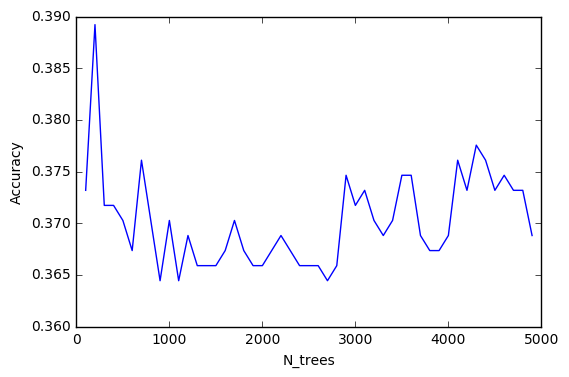

In [242]:
%%time
X_train, X_test, Y_train, Y_test = train_test_split(dataw, y, test_size = 3/7, random_state = 42)
clf = RandomForestClassifier(warm_start = True)
accuracy = []
for i in np.arange(100, 5000, 100):
    clf.fit(X_train, Y_train)
    predictions = clf.predict(X_test)
    clf.set_params(n_estimators = i)
    acc = accuracy_score(predictions, Y_test)
    accuracy.append(acc)
plt.plot(np.arange(100, 5000, 100), accuracy)
plt.xlabel('N_trees')
plt.ylabel('Accuracy')


Однозначно, лес переобучается с некоторого момента и accuracy резко падает примерно после добавления 100 деревьев и больше не возрастает до уровня максимума

### IV. Нейронные сети

*На обучение нейросетей может уйти больше часа, не откладывайте этот пункт на последний день*.

__9 (1 балл)__

В этом задании вам предстоит обучить нейронную сеть на датасете [MNIST](https://en.wikipedia.org/wiki/MNIST_database) с помощью пакета [keras](https://keras.io).

Обучите нейронную сеть с двумя скрытыми слоями в каждой из которых поместите по 100 нейронов. Какого качества удается добиться на тесте?

In [3]:
import keras
from keras.datasets import mnist
import tensorflow
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten
from keras.utils import np_utils
import keras.backend as K
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image


Using TensorFlow backend.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [7]:
np.shape(x_train)

(60000, 28, 28)

In [8]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
#для помощи использовался источник
#https://habrahabr.ru/company/wunderfund/blog/314242/

In [10]:
#удалить
##def get_categorical_accuracy_keras(y_true, y_pred):
  #  return K.mean(K.equal(K.argmax(y_true, axis=1), K.argmax(y_pred, axis=1)))

#https://stackoverflow.com/questions/46305252/valueerror-dimension-1-must-be-in-the-range-0-2-in-keras

In [11]:
batch_size = 128 # in each iteration, we consider 128 training examples at once
num_epochs = 12 # we iterate twenty times over the entire training set
hidden_size = 100 

In [12]:
num_train = 60000 # there are 60000 training examples in MNIST
num_test = 10000 # there are 10000 test examples in MNIST

height, width, depth = 28, 28, 1 # MNIST images are 28x28 and greyscale
num_classes = 10 # there are 10 classes (1 per digit)

(X_train, y_train), (X_test, y_test) = mnist.load_data() # fetch MNIST data

x_train = x_train.reshape(60000, 784)/255
x_test = x_test.reshape(10000, 784)/255
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

In [15]:
%%time
model = Sequential()

model.add(Dense(512, input_shape=(784, ), activation='relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x=x_train, y=y_train, batch_size=512, nb_epoch = 10, verbose=1, validation_data=(x_test, y_test))

//anaconda/lib/python3.5/site-packages/keras/models.py:951: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 8s 129us/step - loss: 0.4105 - acc: 0.8848 - val_loss: 0.1601 - val_acc: 0.9519
Epoch 2/10
60000/60000 [==============================] - 7s 115us/step - loss: 0.1314 - acc: 0.9613 - val_loss: 0.1139 - val_acc: 0.9669
Epoch 3/10
60000/60000 [==============================] - 6s 98us/step - loss: 0.0876 - acc: 0.9737 - val_loss: 0.1030 - val_acc: 0.9684
Epoch 4/10
60000/60000 [==============================] - 6s 100us/step - loss: 0.0642 - acc: 0.9801 - val_loss: 0.0816 - val_acc: 0.9749
Epoch 5/10
60000/60000 [==============================] - 6s 104us/step - loss: 0.0474 - acc: 0.9855 - val_loss: 0.0807 - val_acc: 0.9757
Epoch 6/10
60000/60000 [==============================] - 7s 114us/step - loss: 0.0350 - acc: 0.9901 - val_loss: 0.0675 - val_acc: 0.9791
Epoch 7/10
60000/60000 [==============================] - 7s 109us/step - loss: 0.0266 - acc: 0.9922 - val_loss: 0.0684 - v

In [16]:
model.evaluate(x_test, y_test, verbose=1)

10000/10000 [==============================] - 1s 96us/step


[0.071226880367323608, 0.97909999999999997]

Как видим, полученная accuracy равна 0.979

__10 (2 балл)__
Добавьте сверточные и pooling слои (вы можете также убрать Dense слои), добейтесь большего качества. Для успешного выполнения задания получите accuracy больше 0.99 на тестовой выборке. 

Рекомендации: после сверточных слоев наиболее эффективно добавлять MaxPooling слои, в конце перед последним слоем поставьте Dense слои с достаточно большим количеством нейронов. Подвигайте количество слоев, learning rate, функции активации.

In [17]:
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(input_shape)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Источник: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 283s 5ms/step - loss: 0.2327 - acc: 0.9274 - val_loss: 0.0534 - val_acc: 0.9828
Epoch 2/12
60000/60000 [==============================] - 279s 5ms/step - loss: 0.0732 - acc: 0.9777 - val_loss: 0.0414 - val_acc: 0.9870
Epoch 3/12
60000/60000 [==============================] - 279s 5ms/step - loss: 0.0562 - acc: 0.9826 - val_loss: 0.0344 - val_acc: 0.9876
Epoch 4/12
60000/60000 [==============================] - 275s 5ms/step - loss: 0.0436 - acc: 0.9869 - val_loss: 0.0317 - val_acc: 0.9897
Epoch 5/12
60000/60000 [==============================] - 287s 5ms/step - loss: 0.0380 - acc: 0.9883 - val_loss: 0.0269 - val_acc: 0.9898
Epoch 6/12
60000/60000 [==============================] - 274s 5ms/step - loss: 0.0321 - acc: 0.9902 - val_loss: 0.0253 - val_acc: 0.9917
Epoch 7/12
60000/60000 [=========================

__11 (1 балл)__
Добавьте 1 или 2 dropout слоя внутрь сети предыдущего шага. Удается ли добиться большего качества? Что происходит с процессом обучения? 

In [29]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(input_shape)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

#Источник: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 273s 5ms/step - loss: 0.2278 - get_categorical_accuracy_keras: 0.9289 - val_loss: 0.0520 - val_get_categorical_accuracy_keras: 0.9829
Epoch 2/10
60000/60000 [==============================] - 307s 5ms/step - loss: 0.0713 - get_categorical_accuracy_keras: 0.9782 - val_loss: 0.0373 - val_get_categorical_accuracy_keras: 0.9877
Epoch 3/10
60000/60000 [==============================] - 302s 5ms/step - loss: 0.0526 - get_categorical_accuracy_keras: 0.9837 - val_loss: 0.0317 - val_get_categorical_accuracy_keras: 0.9892
Epoch 4/10
60000/60000 [==============================] - 299s 5ms/step - loss: 0.0418 - get_categorical_accuracy_keras: 0.9870 - val_loss: 0.0284 - val_get_categorical_accuracy_keras: 0.9896
Epoch 5/10
60000/60000 [==============================] - 287s 5ms/step - loss: 0.0345 - get_categorical_accu

Действительно, добавление dropout слегка увеличило качество, возможно это происходит из-за того, что выключение случайных нейронов позволяет избегать переобучнеия,
однако как видим, скорость обучения существенно снижается в данном случае.